# PORTFOLIO EVALUATOR

Evaluates portfolios, calculates performance metrics, and produces graphs for streamlit app.


In [ ]:
# IMPORTS and DISPLAY options
import pandas as pd
from pathlib import Path
import numpy as np
import os, sys, json
import shutil
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter


pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)

DATA_DIR = Path.cwd() / "data"

### 1) Importing the Portfolio

In [2]:
# Change this path to your file
PORTFOLIO_CSV = "final_portfolio_with_returns.csv"  # columns: date,id,weight,stock_ret

In [ ]:
# Load portfolio CSV and prepare columns

csv_path = DATA_DIR / PORTFOLIO_CSV

df = pd.read_csv(csv_path)

def monthly_portfolio_returns(
    df: pd.DataFrame,
    date_col: str = "date",
    weight_col: str = "weight",
    ret_col: str = "stock_ret",
    id_col: str = "id",
    normalize: str = "net",   # "net" -> weights sum to 1 each month; "none" -> use as-is
    round_to: int = 6
) -> pd.DataFrame:
    """
    Convert per-stock weights and returns into a single portfolio return by month.

    Parameters
    ----------
    df : DataFrame
        Must contain columns [id_col, date_col, weight_col, ret_col].
        Example columns: ["id","date","weight","stock_ret"] with date like "2015-01-31".
    normalize : {"net","none"}
        "net" rescales monthly weights so they sum to 1 (long-short allowed; keeps signs).
        "none" uses weights as provided.
    round_to : int
        Decimal places for the output.

    Returns
    -------
    DataFrame with columns:
        year_month : "YYYY-MM"
        pf_monthly_ret : float
    """
    df = df[[id_col, date_col, weight_col, ret_col]].copy()

    # basic hygiene so the portfolio doesn’t trip over NaNs and duplicates
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.dropna(subset=[weight_col, ret_col, date_col])

    # collapse accidental dupes of the same stock in the same month
    df["year_month"] = df[date_col].dt.to_period("M").astype(str)
    df = (df
          .groupby([id_col, "year_month"], as_index=False)
          .agg({weight_col: "sum", ret_col: "first"}))

    # normalize weights per month if requested
    if normalize == "net":
        month_sums = df.groupby("year_month")[weight_col].transform("sum")
        # avoid divide-by-zero if someone zeroed a month’s weights
        df["w_norm"] = np.where(month_sums != 0, df[weight_col] / month_sums, 0.0)
    elif normalize == "none":
        df["w_norm"] = df[weight_col]
    else:
        raise ValueError("normalize must be 'net' or 'none'.")

    # dot product: sum_i w_i,t * r_i,t
    out = (df.assign(wr=df["w_norm"] * df[ret_col])
             .groupby("year_month", as_index=False)["wr"]
             .sum()
             .rename(columns={"wr": "pf_monthly_ret"}))

    if round_to is not None:
        out["pf_monthly_ret"] = out["pf_monthly_ret"].round(round_to)

    return out

df = monthly_portfolio_returns(df)
df


,id,date,weight,stock_ret,year_month
0,comp_002526_01C,2015-01-31,0.000000,-0.054108,2015-01
1,comp_013512_01C,2015-01-31,0.006184,-0.025941,2015-01
2,comp_015007_01C,2015-01-31,0.006160,-0.096157,2015-01
3,comp_015445_01C,2015-01-31,0.006094,1.970622,2015-01
4,comp_016058_01C,2015-01-31,0.006148,-0.071681,2015-01


def load_portfolio(csv_path: str) -> pd.DataFrame:
    """
    Load a monthly-rebalanced portfolio with columns:
      - date: month-end date (string or datetime)
      - id:   security identifier (string/int)
      - weight: portfolio weight at 'date' (should sum to 1 per month)
      - stock_ret: realized return over NEXT month for that id (aligned so that
                   if date = 2005-01-31, this is Feb return)

    Returns a normalized DataFrame with:
      - date (pd.Timestamp, normalized to month-end)
      - year_month (str, 'YYYY-MM')
      - id (str)
      - weight (float)
      - stock_ret (float or NaN)
    """
    df = pd.read_csv(csv_path)

    required = {"date", "id", "weight", "stock_ret"}
    missing = required - set(df.columns)
    if missing:
        raise KeyError(f"Missing required columns: {sorted(missing)}")

    # Parse date and coerce types
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    # Safety: force to period month then back to month-end Timestamp
    df["date"] = df["date"].dt.to_period("M").dt.to_timestamp("M")
    df["year_month"] = df["date"].dt.to_period("M").astype(str)

    # Normalize types
    df["id"] = df["id"].astype(str)
    df["weight"] = pd.to_numeric(df["weight"], errors="coerce")
    df["stock_ret"] = pd.to_numeric(df["stock_ret"], errors="coerce")

    # Sort for consistency
    df = df.sort_values(["date", "id"]).reset_index(drop=True)
    return df

portfolio_df = load_portfolio(csv_path)
portfolio_df.head()

In [4]:
# Check if valid PF: Validate monthly weight sums

def _is_valid_portfolio(
    portfolio_df: pd.DataFrame,
    *,
    weight_col: str = "weight",
    date_col: str = "date",
    tol: float = 1e-6
):
    """
    Check that weights within each month sum to ~1 (within tolerance).

    Returns
    -------
    valid : bool
        True if all months pass the check, False otherwise.
    invalid_rows : pd.DataFrame
        Only the rows (months) where the weights fail.
    """
    if date_col not in portfolio_df.columns:
        raise KeyError(f"Missing '{date_col}' in portfolio_df")

    grp = portfolio_df.groupby(date_col, as_index=False).agg(
        weight_sum=(weight_col, "sum"),
        n_names=(weight_col, lambda x: (x > 0).sum())
    )
    grp["year_month"] = grp[date_col].dt.to_period("M").astype(str)
    grp["deviation"] = grp["weight_sum"] - 1.0
    grp["pass"] = grp["deviation"].abs() <= tol

    invalid_rows = grp.loc[~grp["pass"], ["date", "year_month", "n_names", "weight_sum", "deviation"]]

    all_valid = invalid_rows.empty
    return all_valid, invalid_rows

ok, bad = _is_valid_portfolio(portfolio_df)

print("Portfolio valid?", ok)
if not ok:
    print("Invalid months:")
    display(bad)

Portfolio valid? True


### 2) Evaluation Functions:
THERE ARE LIKELY ISSUES SOMEWHERE HERE

In [5]:
# Monthly Portfolio Return
def monthly_return(
    portfolio_df: pd.DataFrame,
    *,
    id_col: str = "id",
    date_col: str = "date",
    weight_col: str = "weight",
    ret_col: str = "stock_ret"
) -> pd.DataFrame:
    """
    Compute the portfolio monthly return at each month-end 'date'.

    Logic:
      - For each month, zero out weights where the realized return is NaN.
      - Re-scale remaining weights within the month to sum to 1 (across valid rows).
      - The month's portfolio return is sum_i w_eff_i * stock_ret_i.

    Returns DataFrame with:
      - year_month (str, 'YYYY-MM')
      - pf_monthly_ret (float)
    """
    df = portfolio_df.copy()
    if "year_month" not in df.columns:
        df["year_month"] = df[date_col].dt.to_period("M").astype(str)

    # Valid rows per security-month where we have realized returns
    valid = df[ret_col].notna()

    # zero weights where return is NaN, then re-scale within each month
    w = df[weight_col].where(valid, 0.0)
    denom = w.groupby(df[date_col]).transform("sum").replace(0.0, np.nan)
    w_eff = w / denom  # sums to 1 across valid names per date

    mret = (w_eff * df[ret_col]).groupby(df[date_col]).sum(min_count=1)
    out = mret.reset_index(name="pf_monthly_ret")
    out["year_month"] = out[date_col].dt.to_period("M").astype(str)
    return out[["year_month", "pf_monthly_ret"]].sort_values("year_month").reset_index(drop=True)


In [6]:
mret_df = monthly_return(portfolio_df)
mret_df.head()

,year_month,pf_monthly_ret
0,2015-01,0.000790
1,2015-02,0.107385
2,2015-03,0.087724
3,2015-04,0.047421
4,2015-05,0.029017


In [7]:
# Risk / Return Helpers (annualized where relevant)

def cagr(portfolio_df: pd.DataFrame) -> float:
    m = monthly_return(portfolio_df)
    r = pd.to_numeric(m["pf_monthly_ret"], errors="coerce").dropna()
    if r.empty:
        return np.nan
    total_growth = (1.0 + r).prod()
    years = len(r) / 12.0
    if years <= 0:
        return np.nan
    return float(total_growth ** (1.0 / years) - 1.0)

def std(portfolio_df: pd.DataFrame) -> float:
    m = monthly_return(portfolio_df)
    r = pd.to_numeric(m["pf_monthly_ret"], errors="coerce").dropna()
    if r.size == 0:
        return np.nan
    std_m = r.std(ddof=1)
    if np.isnan(std_m):
        return np.nan
    return float(std_m * np.sqrt(12.0))

def sharpe_ratio(
    portfolio_df: pd.DataFrame,
    mkt_csv_path: str = "mkt_ind.csv",
    year_col: str = "year",
    month_col: str = "month",
    rf_col: str = "rf",
    annualize: bool = True,
) -> float:
    # Portfolio monthly returns
    m = monthly_return(portfolio_df)
    r = pd.to_numeric(m["pf_monthly_ret"], errors="coerce")
    r_idx = pd.PeriodIndex(m["year_month"], freq="M")
    r = pd.Series(r.values, index=r_idx).dropna().sort_index()
    if r.size < 2:
        return np.nan

    # Risk-free series from CSV
    mk = pd.read_csv(mkt_csv_path)
    for c in (year_col, month_col, rf_col):
        if c not in mk.columns:
            raise KeyError(
                f"Market CSV must contain '{year_col}', '{month_col}', and '{rf_col}'. "
                f"Got: {mk.columns.tolist()}"
            )
    mk["year_month"] = pd.PeriodIndex.from_fields(
        year=mk[year_col].astype(int),
        month=mk[month_col].astype(int),
        freq="M",
    )
    rf = (
        mk[["year_month", rf_col]]
        .dropna()
        .drop_duplicates(subset=["year_month"])
        .set_index("year_month")[rf_col]
        .astype(float)
        .sort_index()
    )

    # Excess returns aligned
    common = r.index.intersection(rf.index)
    if len(common) < 2:
        return np.nan
    ex = (r.loc[common] - rf.loc[common]).dropna()
    if ex.size < 2:
        return np.nan

    mu_m = ex.mean()
    sd_m = ex.std(ddof=1)
    if sd_m == 0 or np.isnan(sd_m):
        return np.nan

    sr = mu_m / sd_m
    return float(sr * np.sqrt(12.0)) if annualize else float(sr)

def tracking_error(
    portfolio_df: pd.DataFrame,
    mkt_csv_path: str,
    pf_col: str = "pf_monthly_ret",
    year_col: str = "year",
    month_col: str = "month",
    mkt_ret_col: str = "ret",
    annualize: bool = True,
) -> float:
    m = monthly_return(portfolio_df)
    rp = pd.to_numeric(m[pf_col], errors="coerce")
    rp.index = pd.PeriodIndex(m["year_month"], freq="M")
    rp = rp.sort_index().dropna()
    if rp.empty:
        return np.nan

    mk = pd.read_csv(mkt_csv_path)
    for c in (year_col, month_col, mkt_ret_col):
        if c not in mk.columns:
            raise KeyError(
                f"Market CSV must contain '{year_col}', '{month_col}', and '{mkt_ret_col}'. "
                f"Got: {mk.columns.tolist()}"
            )
    mk["year_month"] = pd.PeriodIndex.from_fields(
        year=mk[year_col].astype(int),
        month=mk[month_col].astype(int),
        freq="M",
    )
    rm = (
        mk[["year_month", mkt_ret_col]]
        .dropna()
        .drop_duplicates(subset=["year_month"])
        .set_index("year_month")[mkt_ret_col]
        .astype(float)
        .sort_index()
    )

    idx = rp.index.intersection(rm.index)
    if len(idx) < 2:
        return np.nan

    active = (rp.loc[idx] - rm.loc[idx]).dropna()
    if active.empty:
        return np.nan

    te_m = active.std(ddof=1)
    return float(te_m * np.sqrt(12.0)) if annualize else float(te_m)

def information_ratio(
    portfolio_df: pd.DataFrame,
    mkt_csv_path: str = "mkt_ind.csv",
    year_col: str = "year",
    month_col: str = "month",
    mkt_ret_col: str = "ret",
) -> float:
    m = monthly_return(portfolio_df)
    rp = pd.to_numeric(m["pf_monthly_ret"], errors="coerce")
    rp.index = pd.PeriodIndex(m["year_month"], freq="M")
    rp = rp.sort_index().dropna()
    if rp.size < 2:
        return np.nan

    mk = pd.read_csv(mkt_csv_path)
    for c in (year_col, month_col, mkt_ret_col):
        if c not in mk.columns:
            raise KeyError(
                f"Market CSV must contain '{year_col}', '{month_col}', and '{mkt_ret_col}'. "
                f"Got: {mk.columns.tolist()}"
            )
    mk["year_month"] = pd.PeriodIndex.from_fields(
        year=mk[year_col].astype(int),
        month=mk[month_col].astype(int),
        freq="M",
    )
    rm = (
        mk[["year_month", mkt_ret_col]]
        .dropna()
        .drop_duplicates(subset=["year_month"])
        .set_index("year_month")[mkt_ret_col]
        .astype(float)
        .sort_index()
    )

    idx = rp.index.intersection(rm.index)
    if len(idx) < 2:
        return np.nan
    active = (rp.loc[idx] - rm.loc[idx]).dropna()
    if active.size < 2:
        return np.nan

    te_ann = tracking_error(
        portfolio_df=portfolio_df,
        mkt_csv_path=mkt_csv_path,
        year_col=year_col,
        month_col=month_col,
        mkt_ret_col=mkt_ret_col,
        annualize=True,
    )
    if te_ann is None or np.isnan(te_ann) or te_ann == 0:
        return np.nan

    mu_active_ann = float(active.mean() * 12.0)
    return mu_active_ann / te_ann


In [8]:
# Drawdown, Turnover, and Summary Stats

def drawdown_series(portfolio_df: pd.DataFrame) -> pd.Series:
    m = monthly_return(portfolio_df)
    r = pd.to_numeric(m["pf_monthly_ret"], errors="coerce").dropna()
    if r.empty:
        return pd.Series(dtype=float, name="drawdown")

    idx = pd.PeriodIndex(m.loc[r.index, "year_month"], freq="M")
    r = pd.Series(r.values, index=idx).sort_index()

    cum = (1.0 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1.0

    dd = dd.copy()
    dd.index = dd.index.astype(str)
    dd.name = "drawdown"
    return dd

def turnover(
    portfolio_df: pd.DataFrame,
    id_col: str = "id",
    ym_col: str = "year_month",
    weight_col: str = "weight",
    symmetric: bool = False,
) -> pd.DataFrame:
    df = portfolio_df.copy()
    if ym_col not in df.columns:
        if "date" not in df.columns:
            raise KeyError(f"Need '{ym_col}' or 'date' in portfolio_df.")
        df[ym_col] = pd.to_datetime(df["date"]).dt.to_period("M").astype(str)

    df = df[[id_col, ym_col, weight_col]].dropna(subset=[ym_col])
    held = (
        df[df[weight_col] > 0]
        .groupby(ym_col)[id_col]
        .apply(lambda s: set(s.astype(str)))
        .sort_index()
    )

    results = []
    prev_set = None
    for ym, curr_set in held.items():
        if prev_set is None:
            prev_set = curr_set
            continue
        denom = len(prev_set | curr_set) if symmetric else len(prev_set)
        denom = max(1, denom)
        overlap = len(prev_set & curr_set)
        turn = 1.0 - (overlap / denom)
        results.append((ym, turn))
        prev_set = curr_set

    return pd.DataFrame(results, columns=[ym_col, "turnover"])

def summary_statistics(
    portfolio_df: pd.DataFrame,
    mkt_csv_path: str = "mkt_ind.csv",
) -> pd.DataFrame:
    m = monthly_return(portfolio_df)
    r = pd.to_numeric(m["pf_monthly_ret"], errors="coerce").dropna()

    max_one_m_loss = float(r.min()) if not r.empty else np.nan
    dd = drawdown_series(portfolio_df)
    max_drawdown = float(dd.min()) if dd.size else np.nan
    to_df = turnover(portfolio_df)
    avg_turnover = float(to_df["turnover"].mean()) if not to_df.empty else np.nan

    cagr_val   = cagr(portfolio_df)
    std_val    = std(portfolio_df)
    sharpe_val = sharpe_ratio(portfolio_df, mkt_csv_path=mkt_csv_path)
    ir_val     = information_ratio(portfolio_df, mkt_csv_path=mkt_csv_path)

    stats = pd.DataFrame(
        {
            "metric": [
                "CAGR",
                "STD",
                "Sharpe",
                "IR",
                "Max Drawdown",
                "Max_one_month_loss",
                "Avg_Turnover",
            ],
            "value": [
                cagr_val,
                std_val,
                sharpe_val,
                ir_val,
                max_drawdown,
                max_one_m_loss,
                avg_turnover,
            ],
        }
    )
    return stats


### 3) Calculate Results

In [9]:
# Summary statistics (set your market csv path)
MKT_CSV = DATA_DIR / "mkt_ind.csv"  # expects columns: year, month, rf, ret

In [25]:
# Metrics:
mret_df = monthly_return(portfolio_df)

stats = summary_statistics(portfolio_df, mkt_csv_path=MKT_CSV)

# metrics to express in percent
PCT_METRICS = {"CAGR", "STD", "Max Drawdown", "Max_one_month_loss", "Avg_Turnover"}

stats_pct = stats.copy()
stats_pct.loc[stats_pct["metric"].isin(PCT_METRICS), "value"] *= 100.0

# pretty display: add a formatted string column
def _fmt_row(row):
    if row["metric"] in PCT_METRICS:
        return f"{row['value']:.2f}%"
    if row["metric"] in {"Sharpe", "IR"}:
        return f"{row['value']:.2f}"
    return f"{row['value']:.4f}"

stats_pct["value_formatted"] = stats_pct.apply(_fmt_row, axis=1)
stats_output = stats_pct[["metric", "value_formatted"]].rename(columns={"value_formatted":"value"})
stats_output


,metric,value
0,CAGR,44.22%
1,STD,28.73%
2,Sharpe,1.37
3,IR,1.34
4,Max Drawdown,-26.47%
5,Max_one_month_loss,-23.28%
6,Avg_Turnover,43.55%


### 4) Export Results

In [23]:
# Turn table into Json
stats_dict = {
    row["metric"]: row["value"]
    for _, row in stats.iterrows()
}

main_file = "outputs/metrics.json"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
backup_file = f"outputs/backups/t_metrics_{timestamp}.json"

with open(main_file, "w") as f:
    json.dump(stats_dict, f, indent=4)

print(f"✅ Latest metrics saved to {main_file}")

shutil.copy(main_file, backup_file)

print(f"🗂️ Backup created: {backup_file}")

stats_dict

✅ Latest metrics saved to outputs/metrics.json
🗂️ Backup created: outputs/backups/t_metrics_20251028_163750.json


{'CAGR': 0.4421825190554376,
 'STD': 0.28733283472198623,
 'Sharpe': 1.3703180248762568,
 'IR': 1.3423012794864413,
 'Max Drawdown': -0.2647045639273816,
 'Max_one_month_loss': -0.23275774636265756,
 'Avg_Turnover': 0.4354995684651132}

### 4) Produce Graphs

In [25]:
# ---------- THEME ----------
BRAND = {
    "bg": "white",
    "fg": "#003366",        # deep navy for text/axes
    "grid": "#cce0ff",      # very light blue for gridlines

    # Line colors
    "portfolio": "#e64f3c",       # strong orange/red
    "market":    "#007acc",       # bright blue

    # Fill colors (lighter accents)
    "drawdown_fill_pf": "#f28c3c",   # lighter orange
    "drawdown_fill_mkt": "#66a3ff",  # light blue
}


plt.rcParams.update({
    "figure.figsize": (10, 4.5),
    "figure.facecolor": BRAND["bg"],
    "axes.facecolor": BRAND["bg"],
    "axes.edgecolor": BRAND["fg"],
    "axes.labelcolor": BRAND["fg"],
    "axes.titlecolor": BRAND["fg"],
    "xtick.color": BRAND["fg"],
    "ytick.color": BRAND["fg"],
    "grid.color": BRAND["grid"],
    "grid.linestyle": "-",
    "grid.alpha": 0.6,
    "axes.grid": True,
    "font.size": 12,
    "axes.titlepad": 10,
    "axes.titleweight": "semibold",
    "legend.frameon": False,
    "legend.fontsize": 11,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
})

def _nicely_format_dates(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(6,)))
    ax.grid(True, which="major")
    ax.grid(True, which="minor", axis="x", alpha=0.15)

def _end_label(ax, x, y, label, color, offset=5):
    ax.annotate(
        label,
        xy=(x, y),
        xytext=(offset, 0),
        textcoords="offset points",
        va="center",
        ha="left",
        fontsize=11,
        color=color,
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", edgecolor="none", alpha=0.85),
    )

def _to_ts_index(r_period_idx: pd.PeriodIndex) -> pd.DatetimeIndex:
    return r_period_idx.to_timestamp("M")

# ---------- LOAD MARKET RETURNS ----------
def load_market_returns(
    mkt_csv_path: str,
    year_col: str = "year",
    month_col: str = "month",
    ret_col: str = "ret",
) -> pd.Series:
    mk = pd.read_csv(mkt_csv_path)
    mk["year_month"] = pd.PeriodIndex.from_fields(
        year=mk[year_col].astype(int), month=mk[month_col].astype(int), freq="M"
    )
    r_mkt = (
        mk[["year_month", ret_col]]
        .dropna()
        .drop_duplicates(subset=["year_month"])
        .set_index("year_month")[ret_col]
        .astype(float)
        .sort_index()
    )
    return r_mkt

# ---------- PLOTTING: CUMULATIVE ----------

def plot_cumulative_pretty(
    r_pf: pd.Series,             # monthly portfolio returns (PeriodIndex 'M')
    r_mkt: pd.Series,            # monthly market returns   (PeriodIndex 'M')
    *,
    title: str = "Cumulative Return (Monthly, %)",
    save_path: str | None = None
):
    # align
    common = r_pf.index.intersection(r_mkt.index)
    rpf, rmk = r_pf.loc[common], r_mkt.loc[common]

    # cumulative growth → convert to cumulative return (%)
    cum_pf  = (1 + rpf).cumprod() - 1.0
    cum_mkt = (1 + rmk).cumprod() - 1.0

    idx_ts = _to_ts_index(common)
    cum_pf.index, cum_mkt.index = idx_ts, idx_ts

    fig, ax = plt.subplots()
    l1, = ax.plot(cum_pf, color=BRAND["portfolio"], linewidth=2.4, label="Portfolio")
    l2, = ax.plot(cum_mkt, color=BRAND["market"], linewidth=2.4, label="S&P500")

    _nicely_format_dates(ax)
    ax.set_title(title)
    ax.set_ylabel("Cumulative Return (%)")
    ax.set_xlabel("Date")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # values in [0,1] → show as %

    # end labels as percentages
    _end_label(ax, cum_pf.index[-1], cum_pf.iloc[-1],
               f"{cum_pf.iloc[-1]*100:.1f}%", BRAND["portfolio"])
    _end_label(ax, cum_mkt.index[-1], cum_mkt.iloc[-1],
               f"{cum_mkt.iloc[-1]*100:.1f}%", BRAND["market"])

    ax.legend(loc="upper left")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


# ---------- PLOTTING: DRAWDOWN ----------
def plot_drawdown_pretty(
    r_pf: pd.Series,
    r_mkt: pd.Series,
    *,
    title: str = "Drawdown (Monthly)",
    save_path: str | None = None
):
    common = r_pf.index.intersection(r_mkt.index)
    rpf, rmk = r_pf.loc[common], r_mkt.loc[common]

    def dd_from_r(r: pd.Series) -> pd.Series:
        cg = (1 + r).cumprod()
        peak = cg.cummax()
        return cg / peak - 1.0

    dd_pf  = dd_from_r(rpf)
    dd_mkt = dd_from_r(rmk)

    idx_ts = _to_ts_index(common)
    dd_pf.index, dd_mkt.index = idx_ts, idx_ts

    fig, ax = plt.subplots(figsize=(10, 3.8))
    # filled areas for punchier visuals
    ax.fill_between(dd_pf.index, dd_pf, 0, color=BRAND["drawdown_fill_pf"], alpha=0.18, label="Portfolio")
    ax.plot(dd_pf, color=BRAND["portfolio"], linewidth=2.0)
    ax.fill_between(dd_mkt.index, dd_mkt, 0, color=BRAND["drawdown_fill_mkt"], alpha=0.14, label="S&P 500")
    ax.plot(dd_mkt, color=BRAND["market"], linewidth=2.0)

    _nicely_format_dates(ax)
    ax.set_title(title)
    ax.set_ylabel("Drawdown (%)")
    ax.set_xlabel("Date")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # values in [-1, 0]
    ax.legend(loc="lower left")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


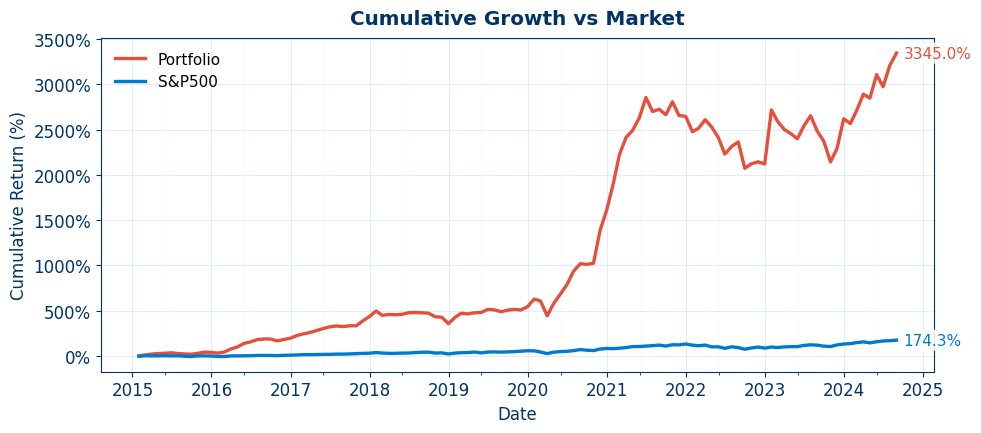

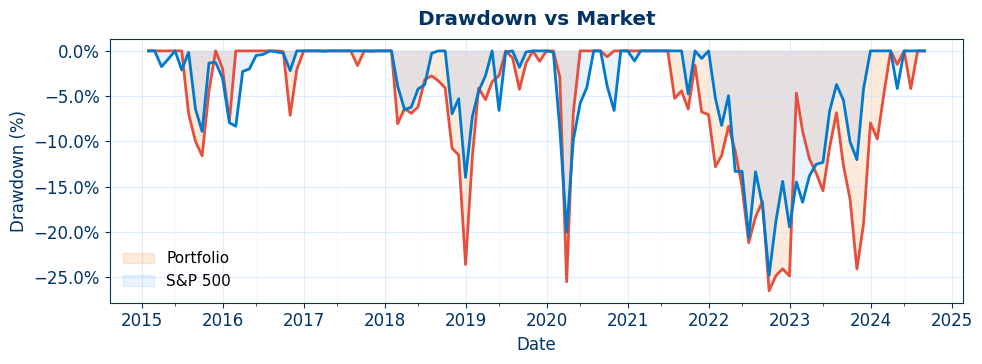

In [27]:
# 1) Portfolio monthly returns (PeriodIndex 'M')
m = monthly_return(portfolio_df)
r_pf = pd.Series(
    pd.to_numeric(m["pf_monthly_ret"], errors="coerce").values,
    index=pd.PeriodIndex(m["year_month"], freq="M"),
).dropna().sort_index()

# 2) Market monthly returns
MKT_CSV = DATA_DIR / "mkt_ind.csv"  # expects columns: year, month, rf, ret
r_mkt = load_market_returns(MKT_CSV)

# 3) Pretty plots
plot_cumulative_pretty(r_pf, r_mkt, title="Cumulative Growth vs Market")
plot_drawdown_pretty(r_pf, r_mkt, title="Drawdown vs Market")

# Save high-DPI images for slides:
#plot_cumulative_pretty(r_pf, r_mkt, title="Portfolio vs S&P500", save_path="cum_indexed.png")
#plot_drawdown_pretty(r_pf, r_mkt, title="Drawdown vs S&P500", save_path="drawdown.png")
